In [60]:
# !pip install  mediapipe
# !pip install fastparquet

### Imports & Initalizations

In [13]:
# import data from mat
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import mediapipe as mp
import glob
from math import cos, sin
import os
import pandas as pd
faceModel = mp.solutions.face_mesh

### Methods

#### Adapting to Mediapipe methods

In [14]:
# get landmarks from mediapipe
def get_landmarks(image_path):
    # load image
    image = cv2.imread(image_path)
    image_scale = image.shape
    with faceModel.FaceMesh(static_image_mode=False, max_num_faces=3) as faces:
        # run inference
        results = faces.process(image)
    if type(results.multi_face_landmarks) == None:
        raise Exception('No face detected!')
    # get landmarks of a single face!
    landmarks = results.multi_face_landmarks[0]
    # print(landmarks)
    return [landmarks, image_scale]
    

In [15]:
# flaten landmarks into 3 lists
def flaten_landmarks(landmarks, image_scale):
    x = []
    y = []
    z = [] 
    for i in range(len(landmarks)):
        x.append(landmarks[i].x * image_scale[1])
        y.append(landmarks[i].y * image_scale[0])
        z.append(landmarks[i].z * image_scale[1])

    return [x, y, z]

#### Main methods

In [16]:
# read_mat function to return pitch, yaw, roll
def read_mat(path):
    landmarks, image_scale = get_landmarks(path)
    landmarks = flaten_landmarks(landmarks.landmark, image_scale)
    landmarks = np.array(landmarks)
    # remove the .jpg extension
    path = path.split('.jpg')[0]
    # add the .mat extension
    path = path + '.mat'
    data = sio.loadmat(path)
    labels = data['Pose_Para'][0][:3]
    pitch, yaw, roll = labels
    return landmarks, pitch, -yaw, roll

In [17]:
# draw the pose axis on the image, and return the image
# tdx, tdy are for the nose position in x, y
def draw_axis(img, yaw, pitch, roll, tdx=None, tdy=None, size = 100):
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

In [18]:
def show_image(path):
    capture = cv2.VideoCapture(path)
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert to RGB format for matplotlib
    
    landmarks, pitch, yaw, roll = read_mat(path)

    nose_x, nose_y = landmarks[0,4], landmarks[1,4]
    plt.imshow(draw_axis(frame, yaw, pitch, roll, nose_x, nose_y))
    plt.show()

    capture.release()
    cv2.destroyAllWindows()

In [19]:
### Testing the graph function

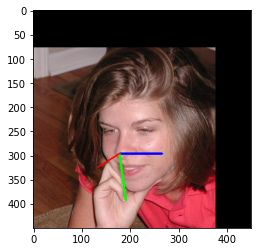

In [20]:
path = 'resources/300W-3D/AFW/134212_1.jpg'
show_image(path)

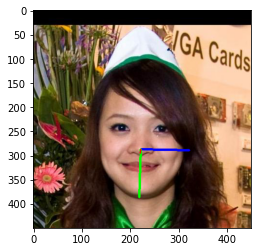

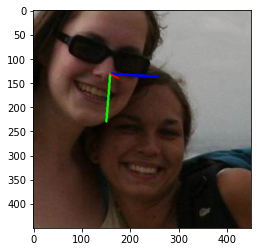

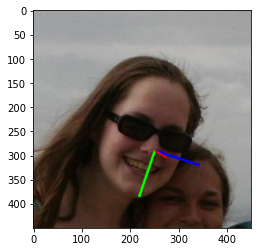

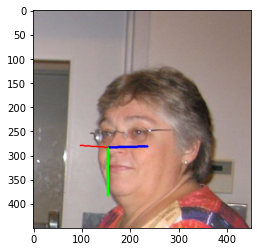

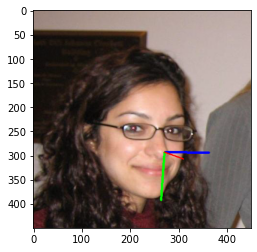

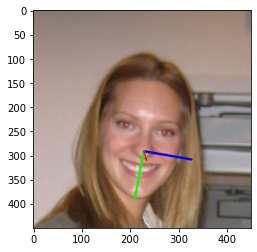

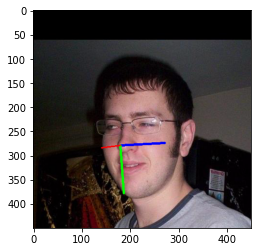

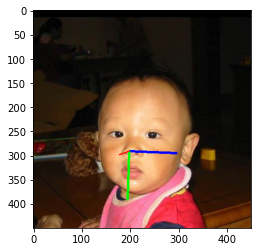

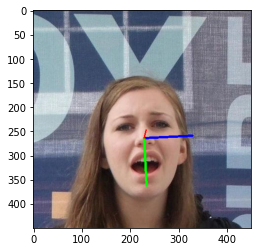

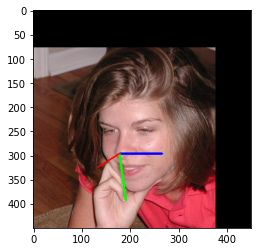

In [21]:
# collect all the image paths in a list
pathes_list = glob.glob('resources/300W-3D/*/*.jpg')
# loop through the list and show the image
for path in pathes_list[:10]:
    show_image(path)

### Building dataframe

In [22]:
path = 'resources/300W-3D/AFW/134212_1.jpg'
landmarks, pitch, yaw, roll = read_mat(path)
landmarks_x = ['x' + str(i) for i in range(landmarks.shape[1])]
landmarks_y = ['y' + str(i) for i in range(landmarks.shape[1])]
features = landmarks_x + landmarks_y
labels = ['pitch', 'yaw', 'roll']
df = pd.DataFrame(columns = features + labels)
# flaten the landmarks into multiple values and add to the dataframe
row = landmarks[:2,:].reshape(1, -1) # adaptation to mediapipe z axis
row = np.append(row, [pitch, yaw, roll]).reshape(1, -1)
df2 =pd.DataFrame(row, columns = features + labels)
df = df.append(df2)
df = df.append(df2)
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y461,y462,y463,y464,y465,y466,y467,pitch,yaw,roll
0,192.401142,180.213104,188.940798,176.408941,178.607064,179.466364,184.460275,149.633507,184.603277,183.116931,...,304.220089,304.397947,252.366525,255.015126,257.456446,246.090612,243.059286,-0.317657,-0.468922,-0.150363
0,192.401142,180.213104,188.940798,176.408941,178.607064,179.466364,184.460275,149.633507,184.603277,183.116931,...,304.220089,304.397947,252.366525,255.015126,257.456446,246.090612,243.059286,-0.317657,-0.468922,-0.150363


In [63]:
# collect all the image paths in a list
pathes_list = glob.glob('resources/300W-3D/*/*.jpg')
# loop through the list and add into a dataframe consisting of image landmarks and pitch, yaw, roll
shape_range = landmarks.shape[1] # make sure you run previous cell first
landmarks_x = ['x' + str(i) for i in range(shape_range)]
landmarks_y = ['y' + str(i) for i in range(shape_range)]
features = landmarks_x + landmarks_y
labels = ['pitch', 'yaw', 'roll']
df = pd.DataFrame(columns = features + labels)

for path in pathes_list:    
    # could be improved by using multiprocessing, and refactorin
    try:
        landmarks, pitch, yaw, roll = read_mat(path)
    except:
        continue
    row = landmarks[:2,:].reshape(1, -1)
    row = np.append(row, [pitch, yaw, roll]).reshape(1, -1)
    df2 =pd.DataFrame(row, columns = features + labels)
    df = df.append(df2)

df.reset_index(inplace=True, drop=True)
df
    

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,y461,y462,y463,y464,y465,y466,y467,pitch,yaw,roll
0,220.807774,221.966596,221.574175,216.498309,222.326656,222.782645,223.915569,167.830002,224.637821,225.036478,...,298.173720,299.393293,250.332204,252.012715,253.303072,248.263147,246.121457,-0.087918,-0.004180,0.026582
1,140.641402,156.221294,147.709250,155.141450,159.633467,161.597970,163.979705,100.044599,168.711014,172.728279,...,144.889645,146.042740,106.412613,106.377040,106.527143,116.339797,114.310397,-0.097263,0.171060,0.078350
2,235.113108,248.443258,241.110259,247.010878,251.443711,253.150696,255.205885,195.548406,259.674391,263.278931,...,302.095807,303.053597,267.727107,267.490187,267.527068,278.477132,276.143664,-0.153185,0.245730,0.337030
3,164.070591,154.942578,165.457347,159.296581,154.763272,158.801888,171.920559,146.825168,176.094639,175.929241,...,294.399878,296.620613,255.850527,257.476401,258.402032,252.943522,248.794359,0.049726,-0.608852,0.005448
4,256.889293,269.968709,260.518563,259.399733,271.250725,269.492322,262.041199,191.560055,261.118117,262.469494,...,304.108724,305.171978,250.783646,252.765611,254.509798,248.424160,244.191742,-0.155008,0.399067,0.074495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3701,210.646588,202.554108,207.511018,194.867662,201.064168,200.732633,201.761582,153.064361,200.952078,199.452764,...,300.868562,302.004263,243.212280,246.855256,249.461666,231.767669,229.085863,-0.094009,-0.166907,-0.168874
3702,204.661520,198.382147,202.634655,191.969320,197.436816,197.619836,199.303700,148.911524,198.984531,198.085427,...,297.630733,298.763484,241.087621,243.995216,246.197176,233.200210,229.586309,-0.084151,-0.242622,-0.078441
3703,241.736716,247.135654,243.812370,239.516357,247.678962,247.262818,245.053053,185.063490,244.495314,244.823241,...,285.900092,287.014174,238.109511,239.879394,241.224629,235.602638,233.180201,-0.146421,0.234853,0.044059
3704,245.439559,238.576081,240.062642,223.869409,236.304599,232.887465,224.265061,169.198063,218.340035,215.341915,...,306.242260,306.938910,247.841370,251.551375,254.368311,231.654802,228.722477,-0.220850,0.076772,-0.255706


In [62]:
# Save df to parquet file
df.to_parquet('resources/parquet/df.parquet')

In [23]:
# load the parquet file
df = pd.read_parquet('resources/parquet/df.parquet')

In [24]:
# Perform PCA on df[features]
from sklearn.decomposition import PCA
pca = PCA(n_components=50).fit(df[features])
pca_df = pd.DataFrame(pca.transform(df[features]), columns = ['pca_' + str(i) for i in range(50)])

In [25]:
pca_df

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_40,pca_41,pca_42,pca_43,pca_44,pca_45,pca_46,pca_47,pca_48,pca_49
0,-57.045700,46.356790,91.476370,-36.311331,-5.400148,-49.465771,43.326296,-2.445989,16.387712,-21.773434,...,0.459596,-0.136447,-0.037504,0.754145,0.312440,-0.272188,-0.586885,0.480032,-0.168125,0.185441
1,-1731.702175,3338.960900,446.165052,-137.579105,-392.211340,183.156480,73.351687,57.118542,27.829074,7.486587,...,-0.833239,-0.438882,0.407211,1.344683,-0.393911,0.297910,-0.036528,-0.123486,-0.280849,-1.056696
2,280.488419,-58.499494,476.075011,108.392195,-74.599882,-23.155720,76.465933,-49.855340,35.119313,-7.672531,...,-0.294013,-1.582447,0.188807,0.287921,0.403689,-0.062004,0.398824,0.029253,-0.130973,-0.862176
3,-963.652213,-46.933446,53.080913,209.346908,49.575798,-10.866622,-24.533748,14.847420,-75.324596,-17.737256,...,-0.152300,-0.408424,1.685990,-0.454060,-0.128196,1.086597,0.129108,0.470305,0.881327,0.502870
4,538.305994,15.895810,123.025072,-96.668631,-94.100214,39.774179,-11.768188,2.398060,-0.878848,-20.188914,...,-1.089478,-0.790126,-0.100249,-1.139662,-0.391086,0.536991,-0.247139,-0.319698,-0.189030,-0.399710
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3700,-288.691421,-7.043189,-164.359012,-93.226556,58.979299,-13.670633,6.568032,25.135604,-33.207834,-1.131177,...,1.453078,-0.546969,0.149044,-0.225224,0.478495,-0.149813,-0.378503,-0.168333,0.619901,0.049245
3701,-412.374403,99.440814,-78.970729,-112.722015,17.977663,-14.524784,4.382278,4.317115,-7.451253,-21.948735,...,1.074248,-0.202590,-0.954222,0.561572,0.382735,0.433158,-0.204674,-0.071091,0.131907,0.457210
3702,317.611359,288.227211,66.310723,-52.357843,5.538451,-57.584342,54.400760,-67.406822,-7.069607,7.430668,...,0.378509,-0.109989,-0.111417,0.699093,0.407933,0.142117,-0.216169,0.062123,0.365475,0.037341
3703,194.855190,-65.381107,-352.702783,-48.171001,-13.727416,42.282394,32.789445,1.439449,3.727104,-21.132457,...,0.171702,-1.008777,0.218842,0.166559,0.265003,-0.010742,-0.018422,-0.028495,-0.088168,0.013399


In [26]:
# split the dataframe into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(pca_df, df[labels], test_size=0.2, random_state=42)
# split y_train into pitch, yaw, roll
y_train_pitch = y_train['pitch']
y_train_yaw = y_train['yaw']
y_train_roll = y_train['roll']
# split y_test into pitch, yaw, roll
y_test_pitch = y_test['pitch']
y_test_yaw = y_test['yaw']
y_test_roll = y_test['roll']

### Building a model

In [75]:
# Import xgboost regression model
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

model1 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42).fit(X_train, y_train_pitch)
model2 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42).fit(X_train, y_train_yaw)
model3 = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42).fit(X_train, y_train_roll)

In [78]:
# model1 = XGBRegressor(n_estimators=50, learning_rate=0.1, max_depth=3, min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, seed=42).fit(X_train, y_train_pitch)
# use SVR instead
import sklearn.svm as svm
model1 = svm.SVR(kernel='rbf', tol=0.01, C=2).fit(X_train, y_train_pitch)
# model2 = svm.SVR(kernel='rbf', tol=0.01, C=2).fit(X_train, y_train_yaw)
model3 = XGBRegressor(n_estimators=1000, max_depth=6, eta=0.1,subsample=1, colsample_bytree=1).fit(X_train, y_train_roll)

In [79]:
# Test the model
y_pred_pitch = model1.predict(X_test)
y_pred_yaw = model2.predict(X_test)
y_pred_roll = model3.predict(X_test)

In [80]:
# Evaluate the model
print('Pitch:')
print('Mean Squared Error:', mean_squared_error(y_test_pitch, y_pred_pitch))
print('R2 Score:', r2_score(y_test_pitch, y_pred_pitch))
print('Mean Absolute Error:', mean_absolute_error(y_test_pitch, y_pred_pitch))
print('Explained Variance Score:', explained_variance_score(y_test_pitch, y_pred_pitch))

print("\n Yaw:")
print('Mean Squared Error:', mean_squared_error(y_test_yaw, y_pred_yaw))
print('R2 Score:', r2_score(y_test_yaw, y_pred_yaw))
print('Mean Absolute Error:', mean_absolute_error(y_test_yaw, y_pred_yaw))
print('Explained Variance Score:', explained_variance_score(y_test_yaw, y_pred_yaw))

print("\n Roll:")
print('Mean Squared Error:', mean_squared_error(y_test_roll, y_pred_roll))
print('R2 Score:', r2_score(y_test_roll, y_pred_roll))
print('Mean Absolute Error:', mean_absolute_error(y_test_roll, y_pred_roll))
print('Explained Variance Score:', explained_variance_score(y_test_roll, y_pred_roll))

Pitch:
Mean Squared Error: 0.00412631214773655
R2 Score: 0.8420678642111237
Mean Absolute Error: 0.04888982235050806
Explained Variance Score: 0.8421952224236076

 Yaw:
Mean Squared Error: 0.002141865437639076
R2 Score: 0.9726415467781002
Mean Absolute Error: 0.028053572548409914
Explained Variance Score: 0.9726432118076215

 Roll:
Mean Squared Error: 0.0014771588713546246
R2 Score: 0.932852970599693
Mean Absolute Error: 0.02263540301883496
Explained Variance Score: 0.9328721610908498


In [81]:
# save the model
import pickle
pickle.dump(model1, open('resources/models/mediapipe_pitch_model.pkl', 'wb'))
pickle.dump(model2, open('resources/models/mediapipe_yaw_model.pkl', 'wb'))
pickle.dump(model3, open('resources/models/mediapipe_roll_model.pkl', 'wb'))

In [82]:
# load the model
import pickle
model1 = pickle.load(open('resources/models/mediapipe_pitch_model.pkl', 'rb'))
model2 = pickle.load(open('resources/models/mediapipe_yaw_model.pkl', 'rb'))
model3 = pickle.load(open('resources/models/mediapipe_roll_model.pkl', 'rb'))

### Graphing the model

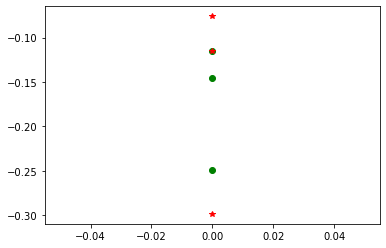

In [83]:
# choose random image from the list
import random
random_path = random.choice(pathes_list)
landmarks, pitch, yaw, roll = read_mat(random_path)
# turn the landmarks into a numpy array
landmarks_ = np.array(landmarks)[:2,:].reshape(1, -1)
landmarks_ = pca.transform(landmarks_)
# predict the pitch, yaw, roll
pitch_pred = model1.predict(landmarks_)
yaw_pred = model2.predict(landmarks_)
roll_pred = model3.predict(landmarks_)
# plot the predicted and actual values
plt.plot(pitch, 'go')
plt.plot(pitch_pred, 'r*')
plt.plot(yaw, 'go')
plt.plot(yaw_pred, 'r*')
plt.plot(roll, 'go')
plt.plot(roll_pred, 'r*')
plt.show()

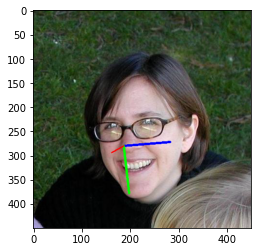

In [84]:
# plot actual values
show_image(random_path)

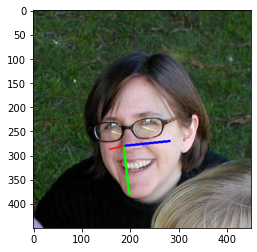

In [85]:
# plot predicted values
capture = cv2.VideoCapture(random_path)
ret, frame = capture.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
nose_x, nose_y = landmarks[0,4], landmarks[1,4]
plt.imshow(draw_axis(frame, yaw_pred, pitch_pred, roll_pred, nose_x, nose_y))
plt.show()

In [86]:
import warnings
warnings.filterwarnings('ignore')

In [89]:
%pylab inline
from IPython.display import clear_output
from imutils import face_utils
import mediapipe as mp
import cv2
frame_count = 0
faceModel = mp.solutions.face_mesh
# path = 'resources/300W-3D/AFW/134212_1.jpg'
capture = cv2.VideoCapture(0)
# capture = cv2.VideoCapture('reference\hamilton\hamilton_clip.mp4')
# warning removed

while capture.isOpened():
    ret, frame = capture.read()
    frame_count += 1
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame = cv2.resize(frame, (450,450))
    image_scale = frame.shape
    if frame_count % 4 == 0:
        with faceModel.FaceMesh(static_image_mode=False) as faces:
            results = faces.process(frame)
            if results.multi_face_landmarks != None:
                landmarks = results.multi_face_landmarks[0] # get single face landmarks
                landmarks = flaten_landmarks(landmarks.landmark, image_scale)
                landmarks = np.array(landmarks)
                for landmarks_cords in landmarks:
                    # print(landmarks_cords)
                    continue
                nose_x, nose_y = landmarks[0,4], landmarks[1,4]
            landmarks_ = landmarks[:2,:].reshape(1,-1)
            landmarks_ = pca.transform(landmarks_)
            pitch_pred = model1.predict(landmarks_)
            yaw_pred = model2.predict(landmarks_)
            roll_pred = model3.predict(landmarks_)
            plt.text(0, 20, 'Pitch: ' + str(pitch_pred[0]), fontsize=10)
            plt.text(0, 40, 'Yaw: ' + str(yaw_pred[0]), fontsize=10)
            plt.text(0, 60, 'Roll: ' + str(roll_pred[0]), fontsize=10)
            plt.imshow(draw_axis(frame, yaw_pred, pitch_pred, roll_pred, nose_x, nose_y))
            plt.show()
            clear_output(wait=True)

KeyboardInterrupt: 

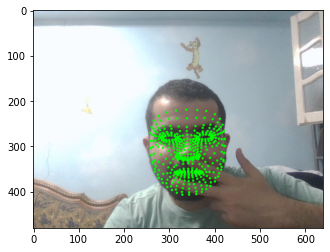

In [ ]:
capture = cv2.VideoCapture(0)
ret, frame = capture.read()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert to RGB format for matplotlib

faceModel = mp.solutions.face_mesh
with faceModel.FaceMesh(static_image_mode=True) as faces:
    results = faces.process(frame)

    if results.multi_face_landmarks != None: 
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
        #   print(dir(face))
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = frame.shape 
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
    plt.imshow(frame)

In [30]:
%pylab inline
from IPython.display import clear_output


capture = cv2.VideoCapture(0)
while capture.isOpened():
    ret, frame = capture.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # convert to RGB format for matplotlib
    with faceModel.FaceMesh(static_image_mode=False, max_num_faces=3) as faces:
        results = faces.process(frame)

        if results.multi_face_landmarks != None: 
          # looping over the faces in the image
          for face in results.multi_face_landmarks:
              for landmark in face.landmark:
                  x = landmark.x
                  y = landmark.y
                  # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                  shape = frame.shape 
                  relative_x = int(x * shape[1])
                  relative_y = int(y * shape[0])
                  # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
                  cv2.circle(frame, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
                  

        plt.imshow(frame)
        plt.show()
        clear_output(wait=True)

KeyboardInterrupt: 